# Fast state tomography with optimal error bounds

Here we are programming the tomographic method described on the paper "Fast state tomography with optimal error bounds". It consists on a "Projected Least Squared" (PLS) estimator approach on the method, where a LS estimator is computed and the projected into the real possible states (as usually LS estimators tend to be non-pyshical).

In [2]:
import numpy as np
import qibo
import matplotlib.pyplot as plt #(pip install --force pillow) in case it does not work
from itertools import product
from qibo.models import QFT
from qibo.models import Circuit
from qibo import gates
import itertools
from qibo.quantum_info import fidelity
from qibo.quantum_info import random_unitary

## Pauli measurements

Explicitely, we are performing
$$
\rho_{LS} = \frac{1}{3^n} \sum_{s,x} f_{s,x} \bigotimes_{k=1}^{n}\left( 3 \ket{(s_k,x_k)} \bra{(s_k,x_k)} - 1 \right),
$$

where $\ket{(s_k,x_k)}$ is nothing more than one of the possible state outcomes of a qubit, that is $\{ \ket{0}, \ket{1}, \ket{+}, \ket{-}, \ket{y+}, \ket{y-}\}$, writen in the computational basis to perform the computations. Also, $f_{s,x}$ is the frequancies outcomes, which usually is computing by running the quantum circuit multiple $N$ times and counting the number of outcomes $n_{s,x}$, that is $f_{s,x} = \frac{n_{s,x}}{N}$. However, we are performing $f_{s,x} = \bra{(s,x)} \rho \ket{(s,x)}$, where $\ket{(s,x)} = \bigotimes_{k}^n \ket{(s_k,x_k)}$. We are doing this because this way we are geting better results, as we know the final state $\rho$ analitically. In practice, and for a big a mount of qubits, we should run the quantum hardware $O(6^n N)$. We would like to compute $f_{s,x}$ with the algorithm of "Learning to predict...", so we only need to run the quantum circuit to compute $h(\rho, O)$. This way, we would have found an "easy" and "not-as-coomputationally-hard-as-other-techniques" algorithm to recontruct an approximation to the quantum state.  

In [3]:
def random_initial_state(nqubits:int):
    """Creates an initial random state.
    
    Given the 6 possible states vector of the Pauli
    matrices (X, Y, Z), it returns an initial state
    which is the random tensor product of all 6 eigensates,
    as well as a list that contains all those initials
    eignestates.

    Attributes:
        nqubits(int): Number of qubits of the quantum 
                      system  
    """
    vec_0 = np.array([1,0])
    vec_1 = np.array([0,1])
    vec_plus = np.array([1,1])/np.sqrt(2)
    vec_minus = np.array([1,-1])/np.sqrt(2)
    vec_yplus = np.array([1,1j])/np.sqrt(2)
    vec_yminus = np.array([1,-1j])/np.sqrt(2)
    initial_list = np.array([vec_0, vec_1, vec_plus, vec_minus, vec_yplus, vec_yminus])
    s_in_lista = []
    index = np.random.choice(len(initial_list))
    psi_in = initial_list[index]
    s_in_lista.append(psi_in)
    for _ in range(nqubits-1):
        index = np.random.choice(len(initial_list))
        s_in = initial_list[index]
        s_in_lista.append(s_in)
        psi_in = np.kron(psi_in, s_in)
    
    return psi_in, s_in_lista 

def function(x, rho_LS, eigenvalues):
    suma = 0
    for lam in eigenvalues:
        suma += np.abs(lam - x)
    return 2 + np.trace(rho_LS) + suma

def bisection(a,b,tol, rho_LS, eigenvalues):
    xl = a
    xr = b
    while (np.abs(xl-xr)>= tol):
        c = (xl+xr)/2.0
        prod = function(xl,rho_LS, eigenvalues)*function(c,rho_LS, eigenvalues)
        if prod >tol:
            xl = c
    return c

def Pauli_basis(nqubits):
    vec_0 = np.array([1,0])
    vec_1 = np.array([0,1])
    vec_plus = np.array([1,1])/np.sqrt(2)
    vec_minus = np.array([1,-1])/np.sqrt(2)
    vec_yplus = np.array([1,1j])/np.sqrt(2)
    vec_yminus = np.array([1,-1j])/np.sqrt(2)
    initial_list = np.array([vec_0, vec_1, vec_plus, vec_minus, vec_yplus, vec_yminus])

    vector_list = []
    vector_basis = product(initial_list, repeat=nqubits)
    for vector in vector_basis:

        vector_list.append(vector)

    vector_list = np.array(vector_list)


    states = []
    for i in range(len(vector_list)):
        kron = np.kron(vector_list[i,0], vector_list[i,1])
        for n in range(2,nqubits):
            kron = np.kron(kron, vector_list[i,n])
        states.append(kron)
    rho_states = []
    for i in range(len(states)):
        rho = np.kron(states[i], np.transpose(np.conjugate([states[i]])))
        rho_states.append(rho)

    return vector_list, rho_states
"""
def rho_LS(f,vector_list,nqubits):
    suma = 0
    for i in range(len(f)):
        kron_0 =  3*np.kron(vector_list[i,0], np.transpose(np.conjugate([vector_list[i,0]]))) - np.eye(2)
        kron_1 =  3*np.kron(vector_list[i,1], np.transpose(np.conjugate([vector_list[i,1]]))) - np.eye(2)
        kron = np.kron(kron_0, kron_1)
        for j in range(2,len(vector_list[i])):
            next = 3*np.kron(vector_list[i,j], np.transpose(np.conjugate([vector_list[i,j]]))) - np.eye(2)
            kron = np.kron(kron, next)
        suma += f[i]*kron

    rho_LS = 1/(3**nqubits)*suma

    return rho_LS
"""


def pseudorandom_circuit(nqubits, density_matrix=None ):
    c = Circuit(nqubits, density_matrix=density_matrix)
    for i in range(nqubits):
        haar_U = random_unitary(2, measure='haar')
        c.add(gates.Unitary(haar_U, i))
    for i in range(nqubits-1):
        c.add(gates.CNOT(i,i+1))
    for i in range(nqubits):
        haar_U = random_unitary(2, measure='haar')
        c.add(gates.Unitary(haar_U, i))
    return c

In [5]:
nqubits=2
psi_in, _ = random_initial_state(nqubits)
#c = Circuit(nqubits, density_matrix=True)
#c.add(gates.H(0))
#c.add(gates.CNOT(0,1))
c = pseudorandom_circuit(nqubits, density_matrix=True)
c.add(gates.M(*range(nqubits)))
final_state = c(np.kron(psi_in, np.transpose(np.conjugate([psi_in]))))
print(final_state)

vector_list, rho_states = Pauli_basis(nqubits)
#computes pseudoprobabiliy vector f
f = []
for kron in rho_states:
    f.append(np.trace(kron@final_state))

suma = 0
for i in range(len(f)):
    kron_0 =  3*np.kron(vector_list[i,0], np.transpose(np.conjugate([vector_list[i,0]]))) - np.eye(2)
    kron_1 =  3*np.kron(vector_list[i,1], np.transpose(np.conjugate([vector_list[i,1]]))) - np.eye(2)
    kron = np.kron(kron_0, kron_1)
    for j in range(2,len(vector_list[i])):
        next = 3*np.kron(vector_list[i,j], np.transpose(np.conjugate([vector_list[i,j]]))) - np.eye(2)
        kron = np.kron(kron, next)
    suma += f[i]*kron

rho_LS = 1/(3**nqubits)*suma
        
        
print(fidelity(np.array(final_state), rho_LS))

(0.00356+0j)|000000><000000| + (-0.00013-0.00054j)|000000><000001| + (0.00139+0.0056j)|000000><000010| + (0.00242+0.00453j)|000000><000011| + (-0.00383+0.00851j)|000000><000100| + (0.00299-0.00261j)|000000><000101| + (0.00277+0.00496j)|000000><000110| + (0.00159+0.00294j)|000000><000111| + (-0.00673+0.00333j)|000000><001000| + (0.00353+9e-05j)|000000><001001| + (-0.00174+0.00659j)|000000><001010| + (-0.00076+0.00443j)|000000><001011| + (0.00086-0.00639j)|000000><001100| + (-0.00088+0.00138j)|000000><001101| + (0.00297+0.00023j)|000000><001110| + (0.00338-0.00063j)|000000><001111| + (-0.00832-0.00849j)|000000><010000| + (0.00118+0.00373j)|000000><010001| + (-0.00146-0.00266j)|000000><010010| + (-0.00069-0.00346j)|000000><010011| + ...
0.9999999999999988


Now that we have got a method to compute $\rho_{LS}$ by the "Least Squared" estimator, we have to project the outcome into the realm of possible real quantum states, as $\rho_{LS}$ tends to be non-physicial (negative eigenvalues). To this end, we perform
$$
\rho_{PLS} = U diag([\lambda - x_0 1]^+)U^{\dagger},
$$
where $\lambda$ and $U$ are the eigenvalues and eigenstates respectively, $1$ is a vector containing all components of one, and $[y]^+ = \text{max}(y,0)$. Also, $x_0$ is chosen to ensure $\text{tr}(\rho_{PLS} = 1)$, and may be determined by finding the roots of the function $f(x) = 2 + \text{tr}(\rho_{LS}) - dx + \sum_{i=1}^{d}|\lambda_i - x| $.

In [5]:
eigenvalues, eigenvectors = np.linalg.eig(rho_LS)

diagonal = np.diag(eigenvalues)
print(eigenvalues)

[ 1.00000000e+00+8.46498265e-18j -9.32556939e-16+5.94258502e-18j
 -6.02120434e-16-6.03122398e-18j  5.53977335e-16+1.21530646e-17j
  4.76012206e-16-1.37717950e-19j -4.38184044e-16-2.90278233e-18j
 -3.67415408e-16-3.47731737e-18j  3.40291243e-16+1.13840197e-17j
 -3.33750794e-16-2.40448696e-18j -2.71417142e-16+4.16420994e-18j
 -2.40396000e-16-3.08803790e-18j  2.50384396e-16+3.84016780e-18j
  2.35378386e-16-3.10612453e-18j -1.88533605e-16-3.64406917e-18j
 -1.73223211e-16+2.42287061e-18j -1.44622884e-16-3.23602027e-18j
  1.79443257e-16-1.64438552e-18j  1.61626122e-16-4.39829388e-18j
  1.45448324e-16+2.19574007e-18j  1.33532462e-16+1.04607692e-17j
 -1.20102371e-16-8.33402332e-18j -9.40249192e-17+5.24591253e-18j
 -8.40396416e-17-2.00612816e-18j -6.39344369e-17+5.76083419e-18j
 -3.84155344e-17-1.20955281e-17j -3.00009935e-17-1.63417837e-18j
  8.26574092e-17+1.20853243e-18j  6.54124101e-17+1.45661847e-17j
  6.17964766e-17+3.50540638e-18j  3.25430818e-17-2.42985853e-18j
  1.70619933e-17+8.989707

39.99999999992724


c:\Users\PW0732YT\anaconda3\envs\VirtualEnv_qibo\lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\PW0732YT\anaconda3\envs\VirtualEnv_qibo\lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


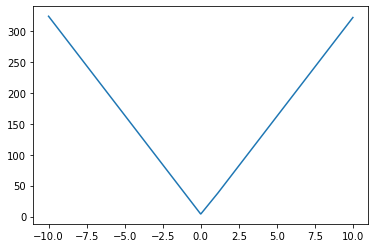

In [6]:
from scipy.optimize import fsolve
x = np.linspace(-10,10,1000)

plt.plot(x, function(x, rho_LS, eigenvalues))

x_0 = bisection(-40,40,1e-10, rho_LS, eigenvalues)
print(x_0)

#root = fsolve(function, x0=0, args=(rho_LS,eigenvalues))

In [6]:
rho_PLS = eigenvectors@np.diag(np.maximum(eigenvalues - 0*np.ones(2**nqubits),0))@np.matrix(eigenvectors).H

NameError: name 'eigenvectors' is not defined

However, we usually do not find $x_0$ such that $f(x_0) = 0$. Thus, we can take $x_0 = 0$ to retive the previous value. So, in that case, $\rho_{LS} = \rho_{PLS}$.

In [4]:
list_nqubits= [2,3,4,5,6]
list_fid = []
for nqubits in list_nqubits:
    psi_in, _ = random_initial_state(nqubits)
    #c = Circuit(nqubits, density_matrix=True)
    #c.add(gates.H(0))
    #c.add(gates.CNOT(0,1))
    c = pseudorandom_circuit(nqubits, density_matrix=True)
    c.add(gates.M(*range(nqubits)))
    final_state = c(np.kron(psi_in, np.transpose(np.conjugate([psi_in]))))
    print(final_state)

    vector_list, rho_states = Pauli_basis(nqubits)
    #computes pseudoprobabiliy vector f
    f = []
    for kron in rho_states:
        f.append(np.trace(kron@final_state))

    suma = 0
    for i in range(len(f)):
        kron_0 =  3*np.kron(vector_list[i,0], np.transpose(np.conjugate([vector_list[i,0]]))) - np.eye(2)
        kron_1 =  3*np.kron(vector_list[i,1], np.transpose(np.conjugate([vector_list[i,1]]))) - np.eye(2)
        kron = np.kron(kron_0, kron_1)
        for j in range(2,len(vector_list[i])):
            next = 3*np.kron(vector_list[i,j], np.transpose(np.conjugate([vector_list[i,j]]))) - np.eye(2)
            kron = np.kron(kron, next)
        suma += f[i]*kron

    rho_LS = 1/(3**nqubits)*suma
    fid = fidelity(np.array(final_state), rho_LS)
    list_fid.append(fid)

[Qibo 0.1.12.dev0|INFO|2024-03-19 16:22:24]: Using qibojit (numba) backend on /CPU:0


(0.25962+0j)|00><00| + (-0.29319+0.24884j)|00><01| + (0.05314-0.0389j)|00><10| + (0.19939-0.01556j)|00><11| + (-0.29319-0.24884j)|01><00| + (0.56961+0j)|01><01| + (-0.0973-0.00701j)|01><10| + (-0.24008-0.17354j)|01><11| + (0.05314+0.0389j)|10><00| + (-0.0973+0.00701j)|10><01| + (0.01671+0j)|10><10| + (0.04314+0.02669j)|10><11| + (0.19939+0.01556j)|11><00| + (-0.24008+0.17354j)|11><01| + (0.04314-0.02669j)|11><10| + (0.15406-0j)|11><11|
(0.0179-0j)|000><000| + (0.00298-0.00817j)|000><001| + (0.05682+0.01446j)|000><010| + (-0.00245+0.0114j)|000><011| + (-0.09219+0.02705j)|000><100| + (0.00514+0.00339j)|000><101| + (0.02212+0.06055j)|000><110| + (-0.01325+0.01818j)|000><111| + (0.00298+0.00817j)|001><000| + (0.00422+0j)|001><001| + (0.00287+0.02833j)|001><010| + (-0.00561+0.00078j)|001><011| + (-0.0277-0.03755j)|001><100| + (-0.00069+0.00291j)|001><101| + (-0.02394+0.02018j)|001><110| + (-0.0105-0.00302j)|001><111| + (0.05682-0.01446j)|010><000| + (0.00287-0.02833j)|010><001| + (0.19206-0

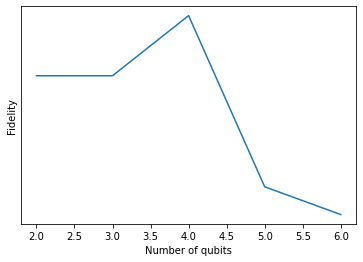

In [6]:
plt.plot(list_nqubits,list_fid)
plt.xlabel('Number of qubits')
plt.ylabel('Fidelity')
plt.yscale('log')
plt.show()

As we can see, the fidelity outcome does not depend on the number of qubits, whichs is interesting (remember that in the ML, the fidelity decreases with the number of qubits, as we need to incresae also the set of POVMs in order to obtain better results (good to chose better distributed POVM???)). Nevertheless, the computational time does increse (how??).